![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [89]:
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np

In [91]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

In [92]:
# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))

In [93]:
data = data.drop(['Model'], axis=1).astype('int')

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [94]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [95]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [96]:
# Celda 1
# Funcion que calcula RMSE
def root_mean_squared_error(y_true, y_pred):
    # Calcular la suma de los cuadrados de las diferencias
    suma_cuadrados = [(true - y_pred) ** 2 for true in y_true]
    # Calcular la media de los errores cuadrados
    mse = sum(suma_cuadrados) / len(y_true)
    return np.sqrt(mse)

In [97]:
# Función que calcula MAE
def mean_absolute_error(y_true, y_pred):
    # Calcular la suma de las diferencias absolutas
    errores_abs = [abs(true - y_pred) for true in y_true]
    # Calcular la media de los errores absolutos
    mae = sum(errores_abs) / len(y_true)
    return mae

In [98]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, float('inf'), float('inf')]  # j, split, rmse, mae
    
    # Para todas las varibles 
    for j in features:
        unique_values = np.unique(X.iloc[:, j])
        
        # Verificar si la variable es booleana
        if len(unique_values) == 2 and np.all(unique_values == [0, 1]):
            split = unique_values[0]
            rmse_0 = root_mean_squared_error(y[X.iloc[:, j]==0], np.mean(y[X.iloc[:, j]==0]))
            rmse_1 = root_mean_squared_error(y[X.iloc[:, j]==1], np.mean(y[X.iloc[:, j]==1]))
            mae_0 = mean_absolute_error(y[X.iloc[:, j]==0], np.mean(y[X.iloc[:, j]==0]))
            mae_1 = mean_absolute_error(y[X.iloc[:, j]==0], np.mean(y[X.iloc[:, j]==0]))
            
            rmse = (rmse_0 + rmse_1)/2  # RMSE promedio de ambas ramas
            mae = (mae_0 + mae_1)/2   # MAE promedio de ambas ramas

            if rmse < best_split[2]:
                    best_split = [j, split, rmse, mae]
            
        else:
            # Si la variable es numerica, realizar particiones
            splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
            splits = np.unique(splits)[1:]
        
            # Para cada partición
            for split in splits:
                rmse_left = root_mean_squared_error(X[X.iloc[:, j] < split].iloc[:,j], np.mean(y[X.iloc[:, j] < split]))
                rmse_right = root_mean_squared_error(X[X.iloc[:, j] >= split].iloc[:,j], np.mean(y[X.iloc[:, j] >= split]))
                mae_left = mean_absolute_error(X[X.iloc[:, j] < split].iloc[:,j], np.mean(y[X.iloc[:, j] < split]))
                mae_right = mean_absolute_error(X[X.iloc[:, j] < split].iloc[:,j], np.mean(y[X.iloc[:, j] < split]))
                
                rmse = (rmse_left + rmse_right)/2  # RMSE promedio de ambas ramas
                mae = (mae_left + mae_right)/2     # MAE promedio de ambas ramas
                
                if rmse < best_split[2]:
                    best_split = [j, split, rmse, mae]
    
    return best_split

In [99]:
def tree_grow_reg(X, y, level=0, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0, mae=0)
        return tree
    
    j, split, rmse, mae = best_split(X, y, num_pct)
    
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], rmse=rmse, mae=mae)
    
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    filter_l = X.iloc[:, j] <= split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    tree['sl'] = tree_grow_reg(X_l, y_l, level + 1, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow_reg(X_r, y_r, level + 1, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [100]:
tree=tree_grow_reg(X_test, y_test, level=0, max_depth=2, num_pct=10)


In [101]:
print("RMSE:", tree['rmse'])
print("MAE:", tree['mae'])

RMSE: 2971.838138555363
MAE: 2520.593176533343


### Conclusión:
Acá nos podemos dar cuenta de que el modelo no es muy preciso. Sin embargo, este principio básico nos puede ayudar a desarrollar modelos de ensamblaje mucho más precisos y complejos

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [102]:
data['Price'].describe()

count    10495.000000
mean     14538.403716
std       3922.420961
min       5002.000000
25%      11999.000000
50%      15000.000000
75%      16999.000000
max      32444.000000
Name: Price, dtype: float64

In [103]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Creación de 10 muestras de bootstrap 
np.random.seed(123)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B+1)]

# Definicion del arbol
treereg = DecisionTreeRegressor(max_depth=None, random_state=123)

# DataFrame para guardar las predicciones de cada árbol
y_pred = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test
for i, sample in enumerate(samples):
    X_train_sample = X_train.iloc[sample,:]
    y_train_sample = y_train.iloc[sample]
    treereg.fit(X_train_sample, y_train_sample)
    y_pred.iloc[:,i] = treereg.predict(X_test)


In [104]:
# RMSE de cada árbol
for i in range(n_B):
    print('Árbol ', i, 'tiene un RMSE de: ', "{:.2f}".format(np.sqrt(mean_squared_error(y_pred.iloc[:,i], y_test))))

Árbol  0 tiene un RMSE de:  2141.61
Árbol  1 tiene un RMSE de:  2136.35
Árbol  2 tiene un RMSE de:  2122.72
Árbol  3 tiene un RMSE de:  2087.28
Árbol  4 tiene un RMSE de:  2168.52
Árbol  5 tiene un RMSE de:  2113.88
Árbol  6 tiene un RMSE de:  2127.93
Árbol  7 tiene un RMSE de:  2184.41
Árbol  8 tiene un RMSE de:  2138.11
Árbol  9 tiene un RMSE de:  2132.10


In [105]:
# RMSE al promediar todas las predicciones en cada arboles construidos
np.sqrt(mean_squared_error(y_test, y_pred.mean(axis=1)))

1796.4355868399332

### Conclusión:
La media de los precios es 14,538.40 y la desviación estándar es 3922.42. Comparando el RMSE de 1796 con la desviación estándar, observamos que el RMSE es aproximadamente el 45% de la desviación estándar. Este valor sugiere que el modelo tiene un desempeño moderadamente bueno, ya que un RMSE mucho menor que la desviación estándar indica que el modelo captura una cantidad significativa de la variabilidad en los datos.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [106]:
# Celda 3
from sklearn.ensemble import BaggingRegressor

bagreg = BaggingRegressor(DecisionTreeRegressor(max_features='log2'),
                          n_estimators=10,
                          bootstrap=True, 
                          oob_score=True, 
                          random_state=1)

In [107]:
# Entrenar el modelo con el conjunto de entrenamiento
bagreg.fit(X_train, y_train)
# Predicir en el conjunto de test
y_pred_bag = bagreg.predict(X_test)

In [108]:
# Cálculo del error del modelo
np.sqrt(mean_squared_error(y_test, y_pred_bag))

1824.7000069648657

### Conclusión:
Acá, nos podemos dar cuenta de lo simple que es desarrollar estos modelos con librería.

Sin embargo, también vemos un desempéño un poco por debajo que el obtenido en el Bagging manual.
 
Esto se debe a la falta de calibración de parámetros en el modelos.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [109]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
rfreg = RandomForestRegressor()

# Entrenar el modelo con el conjunto de entrenamiento
rfreg.fit(X_train, y_train)

# Predicir en el conjunto de test
y_pred_rf = rfreg.predict(X_test)

# Cálculo de error del modelo
np.sqrt(mean_squared_error(y_test, y_pred_rf))

1757.4790838730512

### Conclusión:
El uso de modelos de ensamblaje como en este caso el random forest, nos ayuda a mejorar la predicción del modelo. 

Esto se ve reflejado en la mejora obtenida del RMSE.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

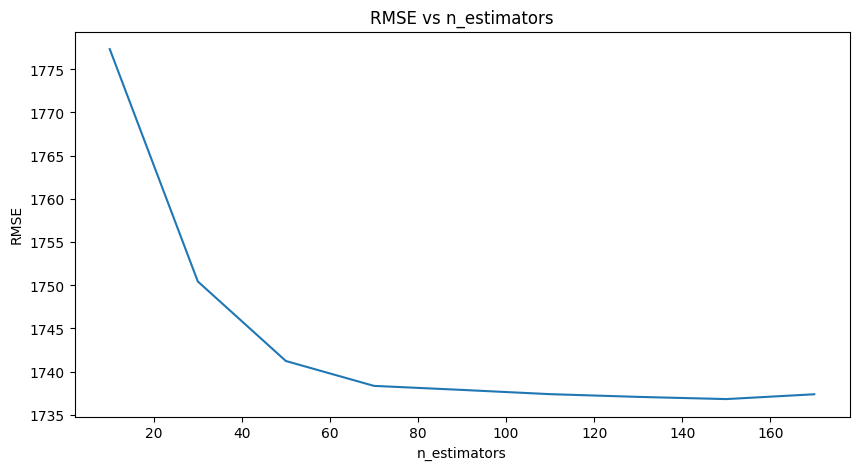

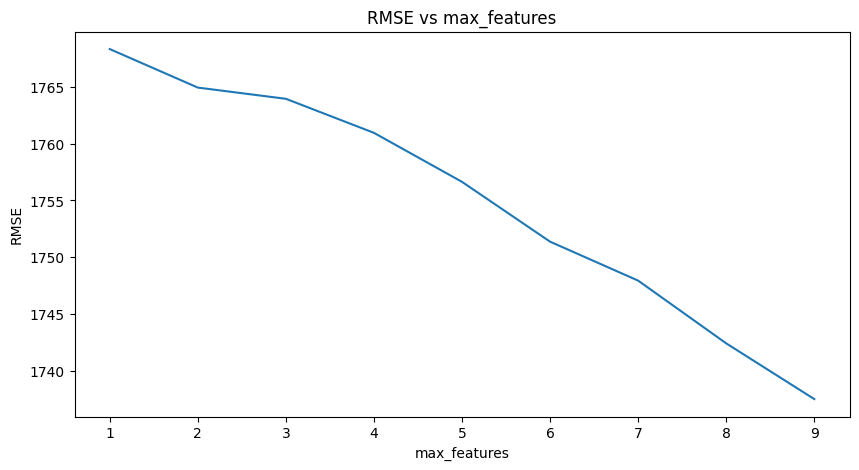

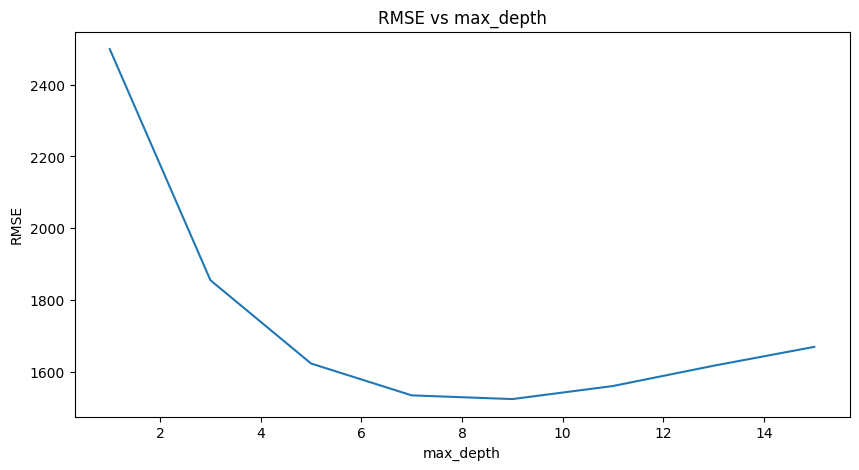

In [110]:
# Celda 5
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# diferentes valores de n_estimators
estimator_range = range(10, 190, 20)
rmse_scores_estimators = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, random_state=42)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores_estimators.append(np.mean(np.sqrt(-mse_scores)))

# Gráfica  n_estimators
plt.figure(figsize=(10, 5))
plt.plot(estimator_range, rmse_scores_estimators)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
plt.title('RMSE vs n_estimators')
plt.show()

#diferentes valores de max_features
feature_range = range(1, X_train.shape[1] + 1)
rmse_scores_features = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=42)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores_features.append(np.mean(np.sqrt(-mse_scores)))

# Gráfica max_features
plt.figure(figsize=(10, 5))
plt.plot(feature_range, rmse_scores_features)
plt.xlabel('max_features')
plt.ylabel('RMSE')
plt.title('RMSE vs max_features')
plt.show()

#diferentes max_depths
depth_range = range(1, 17, 2)
rmse_scores_depth = []

# Uso de un 5-fold cross-validation para cada valor de max_depth
for depth in depth_range:
    rf = RandomForestRegressor(n_estimators=100, max_features=int(np.sqrt(X_train.shape[1])), max_depth=depth, random_state=42)
    mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_scores_depth.append(np.mean(np.sqrt(-mse_scores)))

# Gráfica max_depth
plt.figure(figsize=(10, 5))
plt.plot(depth_range, rmse_scores_depth)
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('RMSE vs max_depth')
plt.show()


In [111]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

# Configuración del modelo con los parámetros elegidos
rf = RandomForestRegressor(n_estimators=70, max_features='sqrt', max_depth=9, random_state=42)

# Evaluación del modelo utilizando cross-validation
mse_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Cálculo del RMSE
rmse_scores = np.sqrt(-mse_scores)
mean_rmse_rf = np.mean(rmse_scores)

print("RMSE promedio en validación cruzada:", mean_rmse_rf)

RMSE promedio en validación cruzada: 1523.9389624172418


### Conclusión:
El RMSE promedio de 1523.94 obtenido en la validación cruzada para tu modelo de Random Forest indica un rendimiento sólido. 

Este resultado muestra una mejora significativa en la precisión de las predicciones, comparado con iteraciones anteriores del modelo. 

La configuración del modelo incluyó n_estimators optimizado a 70 y max_depth ajustado entre 7 y 9, con max_features configurado en 'sqrt', lo que implica usar la raíz cuadrada del número total de características para diversificar los árboles y reducir el riesgo de sobreajuste.

Este modelo bien ajustado sugiere una buena capacidad para generalizar y es adecuado para aplicaciones prácticas.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [112]:
# Celda 6
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

# RMSE
rmse = np.sqrt(mse)

print("El RMSE del modelo XGBoost:", rmse)


El RMSE del modelo XGBoost: 1605.2355199928948


### Conclusión:
El modelo de XGBoost tiene una gran mejoría respecto al modelo de Random forest sin calibrar los parámetros. Sin embargo, se necesita su calibración para mejorar su desempeño.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

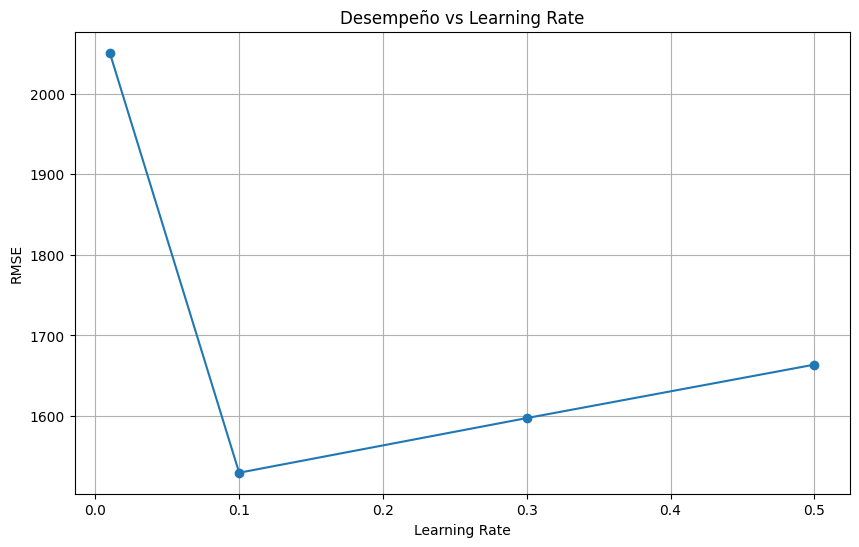

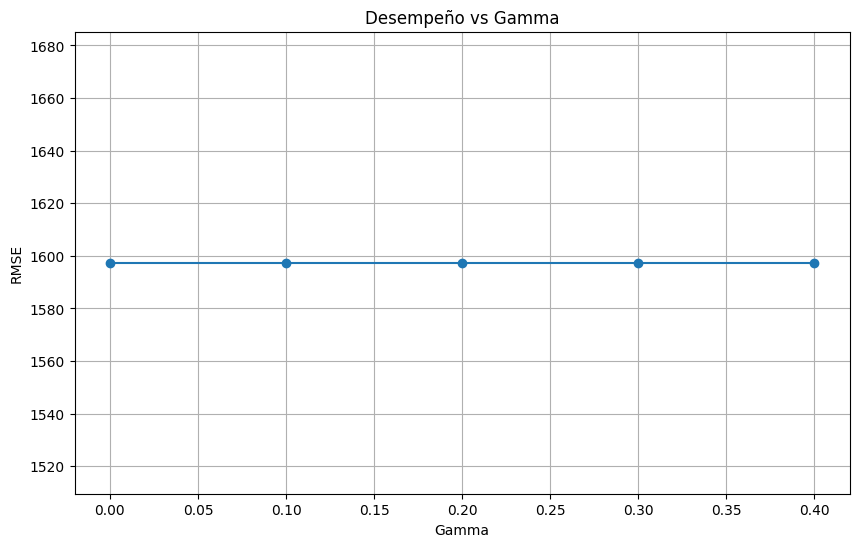

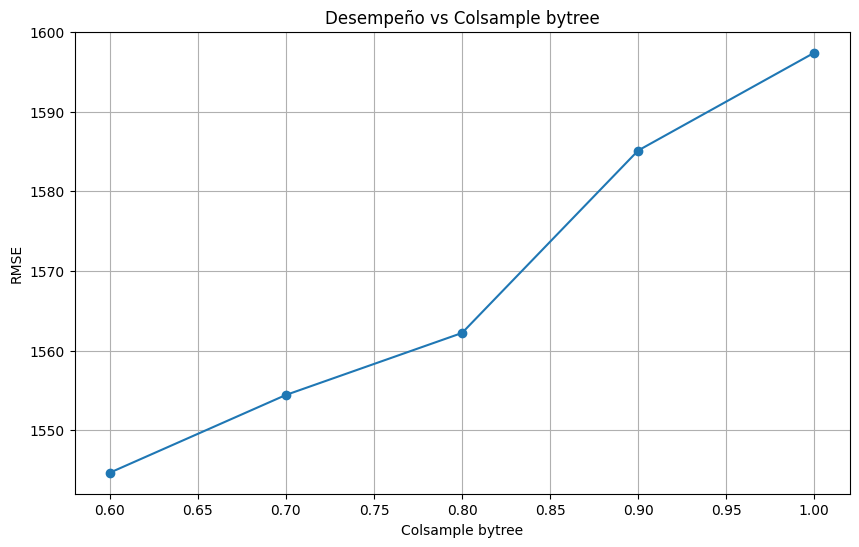

Mejor Learning Rate: 0.1
Mejor Gamma: 0
Mejor Colsample bytree: 0.6


In [113]:
#parametros
learning_rates = [0.01, 0.1, 0.3, 0.5]
gammas = [0, 0.1, 0.2, 0.3, 0.4]
colsamples_bytree = [0.6, 0.7, 0.8, 0.9, 1.0]

# rmse
rmses_lr = []
rmses_gamma = []
rmses_colsample = []

num_splits = 5

for lr in learning_rates:
    xgb_model = XGBRegressor(learning_rate=lr)
    rmse = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=num_splits, scoring='neg_mean_squared_error').mean())
    rmses_lr.append(rmse)

for gamma in gammas:
    xgb_model = XGBRegressor(gamma=gamma)
    rmse = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=num_splits, scoring='neg_mean_squared_error').mean())
    rmses_gamma.append(rmse)

for colsample in colsamples_bytree:
    xgb_model = XGBRegressor(colsample_bytree=colsample)
    rmse = np.sqrt(-cross_val_score(xgb_model, X_train, y_train, cv=num_splits, scoring='neg_mean_squared_error').mean())
    rmses_colsample.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, rmses_lr, marker='o')
plt.title('Desempeño vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(gammas, rmses_gamma, marker='o')
plt.title('Desempeño vs Gamma')
plt.xlabel('Gamma')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(colsamples_bytree, rmses_colsample, marker='o')
plt.title('Desempeño vs Colsample bytree')
plt.xlabel('Colsample bytree')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

best_lr = learning_rates[np.argmin(rmses_lr)]
best_gamma = gammas[np.argmin(rmses_gamma)]
best_colsample = colsamples_bytree[np.argmin(rmses_colsample)]

print("Mejor Learning Rate:", best_lr)
print("Mejor Gamma:", best_gamma)
print("Mejor Colsample bytree:", best_colsample)

In [116]:

best_xgb_model = XGBRegressor(learning_rate=best_lr, gamma=best_gamma, colsample_bytree=best_colsample)
best_xgb_model.fit(X_train, y_train)


y_pred = best_xgb_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)


rmse_xgboost = np.sqrt(mse)

print("RMSE xboost:", rmse_xgboost)


RMSE xboost: 1544.701160904418


* Learning Rate (learning_rate): Controla el sobreajuste por medio de una tasa de aprendizaje.

* Gamma (gamma): Es un parámetro de regularización que controla cuánta reducción de error se requiere para hacer que se divida un nodo en un árbol. 

* Colsample bytree (colsample_bytree): Es la fracción de características que se utilizarán para construir cada árbol. 

### Conclusión:
El modelo de random forest tiene un mejor rendimiento que el modelo de xgboost.

Además, este es más interpetrable.

Finalmente, nos pudimos darnos cuenta que la calibración de parámetros mejora significativamente el modelo.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

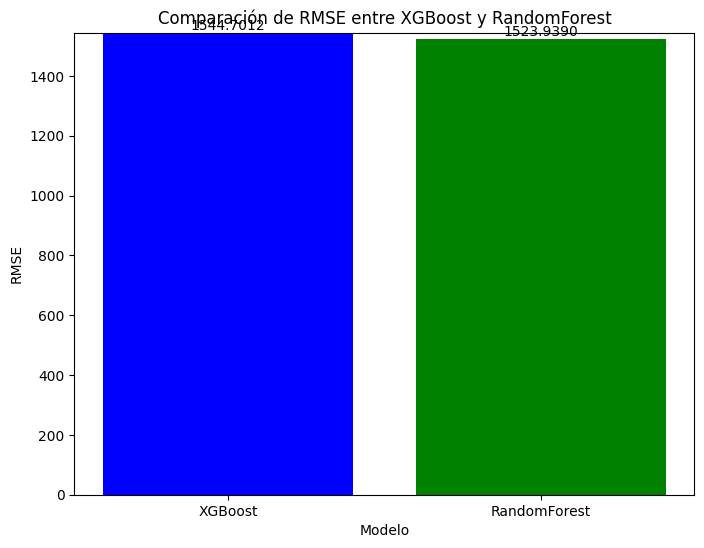

In [117]:
# Celda 8

model_names = ['XGBoost', 'RandomForest']
rmse_values = [rmse_xgboost, mean_rmse_rf]


plt.figure(figsize=(8, 6))
plt.bar(model_names, rmse_values, color=['blue', 'green'])
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de RMSE entre XGBoost y RandomForest')
for i in range(len(model_names)):
    plt.text(i, rmse_values[i], f'{rmse_values[i]:.4f}', ha = 'center', va = 'bottom')
plt.ylim(0, max(rmse_values) + 0.05)  
plt.show()


* El modelo del Random Forest tuvo un mejor desempeño para este problema.
* El modelo XGBoost se realiza en manera secuencial, por lo tanto, su implementación es más costosa y demorada que la del Random Forest.
* El modelo del Random Forest es más interpretable.
* El modelo de XGBoost aún tiene muchos más parametros calibrables que pueden ayudar a mejorar el desempeño, incluso más que vs el Random Forest